In [50]:
import pydicom
import os, sys, time, datetime, re
import numpy as np
from pathlib import Path
import requests
import SimpleITK as sitk
import math
import matplotlib.pyplot as plt
import pydicom._storage_sopclass_uids

directoryPath = Path("D:/data/CT-Covid-19-August2020/")
print(directoryPath)

path_to_file = []
for root, dirs, files in os.walk(directoryPath):
    for name in files:
        if name.endswith(".nii"):
            path_to_file.append(os.path.join(root, name))
            
len(path_to_file)

D:\data\CT-Covid-19-August2020


650

In [51]:
suffix = '.dcm'  # output file suffix
# SELECTING A FILEPATH/PATIENT
for ii in range(len(path_to_file)):
    a_filepath = path_to_file[ii]
    head, tail = os.path.split(a_filepath)
    patient_code_file = os.path.splitext(tail)[0]

    save_directory = os.path.join(directoryPath,"DICOM", patient_code_file)
    print(patient_code_file)
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    regex = re.compile(r'(?<=-)\d+')
    patient_code = regex.findall(patient_code_file)[0]


    reader = sitk.ImageFileReader()
    reader.SetFileName(a_filepath)
    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    # Read Metadata

    for k in reader.GetMetaDataKeys():
        v = reader.GetMetaData(k)
    #    print(f"({k}) = = \"{v}\"")

    reader.SetImageIO("NiftiImageIO")
    image = reader.Execute();

    print("Image Size is:" + str(image.GetSize()))
    nda = sitk.GetArrayFromImage(image)
    print("Numpy Array Size:" + str(nda.shape))

    # Metadata from NifTI
    VoxelSize = np.asarray([float(reader.GetMetaData('pixdim[1]')), float(reader.GetMetaData('pixdim[2]')), float(reader.GetMetaData('pixdim[3]'))])

    # Image Origin
    if float(reader.GetMetaData('pixdim[0]')) == -1:
        qfac=-1
    else:
        qfac=1
    ijk_vec = np.asarray([-1, -1, qfac*1])[:,np.newaxis]
    quat = [math.sqrt(1-float(reader.GetMetaData('quatern_b'))**2-float(reader.GetMetaData('quatern_c'))**2-float(reader.GetMetaData('quatern_d'))**2),
                   float(reader.GetMetaData('quatern_b')), 
                   float(reader.GetMetaData('quatern_c')), 
                   float(reader.GetMetaData('quatern_d'))]
    qoffset_vec = np.asarray([-float(reader.GetMetaData('qoffset_x')), -float(reader.GetMetaData('qoffset_y')), float(reader.GetMetaData('qoffset_z'))])[:,np.newaxis]
    print(quat)
    R = np.asarray([[quat[0]**2+quat[1]**2-quat[2]**2-quat[3]**2, 2*(quat[1]*quat[2]-quat[0]*quat[3]), 2*(quat[1]*quat[3]+quat[0]*quat[2])],
                    [2*(quat[1]*quat[2]+quat[0]*quat[3]), quat[0]**2+quat[2]**2-quat[1]**2-quat[3]**2, 2*(quat[2]*quat[3]-quat[0]*quat[1])],
                    [2*(quat[1]*quat[3]-quat[0]*quat[2]), 2*(quat[2]*quat[3]+quat[0]*quat[1]), quat[0]**2+quat[3]**2-quat[1]**2-quat[2]**2]])



    ImageOrigin = np.matmul(R,ijk_vec) * VoxelSize[:,np.newaxis] + qoffset_vec
    k_deets = reader.GetMetaDataKeys()
    print(ImageOrigin)
    """
    # OLD, using NIBABEL to pull information out of header
    # Voxel size is RL-AP-IS
    # Identify image origin
    # NIFTI assumes RAS
    # DICOM assumes LPS
    # Must convert by flipping signs of the first 2 coordinates in ijk_vec

    """
    #plt.imshow(nda[170,:,:])
    #plt.plot
    print(np.min(nda[:]), np.max(nda[:]))
    
    # WRITE DICOM FILE SERIES USING PYDICOM
    nda2 = np.moveaxis(nda, 0, -1)
    print(nda2.dtype)

    

    print("Writing Dicom Metadata")
    series_uid = pydicom.uid.generate_uid()
    study_uid = pydicom.uid.generate_uid()
    FoR_uid = pydicom.uid.generate_uid()
    print("Writing Dicom Files for:" + str(save_directory))
    for i in range(nda2.shape[2]):
        # Save file_path for each slice:
        save_filepath = os.path.join(save_directory,str(patient_code)+"_"+str(i)+suffix)

        file_meta = pydicom.dataset.Dataset()
        file_meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.EnhancedCTImageStorage
        file_meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
        file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
        file_meta.ImplementationClassUID = pydicom.uid.PYDICOM_IMPLEMENTATION_UID

        # Remaining DICOM tags
        #print("Writing Dicom Dataset")
        ds = pydicom.dataset.Dataset()
        ds.file_meta = file_meta

        # Transfer Syntax
        ds.is_little_endian = True
        ds.is_implicit_VR = False

        # DICOM metadata tags:
        ds.SOPClassUID = ds.file_meta.MediaStorageSOPClassUID
        ds.SOPInstanceUID = ds.file_meta.MediaStorageSOPInstanceUID
        ds.Modality = "CT"
        ds.SeriesInstanceUID = series_uid
        ds.StudyInstanceUID = study_uid
        ds.FrameOfReferenceUID = FoR_uid

        dt = datetime.datetime.now()
        ds.ContentDate = dt.strftime('%Y%m%d')
        ds.SeriesDate = dt.strftime('%Y%m%d')
        timeStr = dt.strftime('%H%M%S.%f')  # long format with micro seconds
        ds.ContentTime = timeStr

        ds.PatientName = patient_code
        ds.PatientID = patient_code
        ds.ImagePositionPatient = str(ImageOrigin[0][0])+"\\"+str(ImageOrigin[1][0])+"\\"+str(ImageOrigin[2][0]+i*VoxelSize[2])
        ds.ImageOrientationPatient = r"1\0\0\0\1\0"
        ds.AnatomicalOrientationType = "BIPED"
        ds.PixelSpacing = str(VoxelSize[0])+"\\"+str(VoxelSize[1])
        ds.SliceThickness = VoxelSize[2]

        ds.NumberOfFrames = "1"
        ds.BitsStored = 16
        ds.BitsAllocated = 16
        ds.SamplesPerPixel = 1
        ds.HighBit = 15

        ds.ImagesInAcquisition = "1"

        ds.Rows = nda2.shape[0]
        ds.Columns = nda2.shape[1]
        ds.InstanceNumber = 1

        ds.ImageType = r"DERIVED\AXIAL"

        ds.RescaleType = "HU"
        ds.RescaleIntercept = "0"
        ds.RescaleSlope = "1"
        ds.PhotometricInterpretation = "MONOCHROME2"
        ds.PixelRepresentation = 1

        pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)
        #print("Setting pixel data...")
        ds.PixelData = nda2[:,:,i].tobytes()

        #print("Writing files: ", save_filepath)
        ds.save_as(save_filepath, write_like_original=False)
    
print("ALL files saved.")

volume-covid19-A-0000
Image Size is:(512, 512, 341)
Numpy Array Size:(341, 512, 512)
[0.0, 0.0, 0.0, 1.0]
[[-191.856]
 [-188.732]
 [-965.   ]]
-2169 10382
int16
Writing Dicom Metadata
Writing Dicom Dataset
Setting pixel data...
Writing files:  D:\data\CT-Covid-19-August2020\DICOM\volume-covid19-A-0000\0000_0.dcm
Writing Dicom Dataset
Setting pixel data...
Writing files:  D:\data\CT-Covid-19-August2020\DICOM\volume-covid19-A-0000\0000_1.dcm
Writing Dicom Dataset
Setting pixel data...
Writing files:  D:\data\CT-Covid-19-August2020\DICOM\volume-covid19-A-0000\0000_2.dcm
Writing Dicom Dataset
Setting pixel data...
Writing files:  D:\data\CT-Covid-19-August2020\DICOM\volume-covid19-A-0000\0000_3.dcm
Writing Dicom Dataset
Setting pixel data...
Writing files:  D:\data\CT-Covid-19-August2020\DICOM\volume-covid19-A-0000\0000_4.dcm
Writing Dicom Dataset
Setting pixel data...
Writing files:  D:\data\CT-Covid-19-August2020\DICOM\volume-covid19-A-0000\0000_5.dcm
Writing Dicom Dataset
Setting pixel 

int16
Writing Dicom Metadata
Writing Dicom Dataset
Setting pixel data...
Writing files:  D:\data\CT-Covid-19-August2020\DICOM\volume-covid19-A-0005\0005_0.dcm
Writing Dicom Dataset
Setting pixel data...
Writing files:  D:\data\CT-Covid-19-August2020\DICOM\volume-covid19-A-0005\0005_1.dcm
Writing Dicom Dataset
Setting pixel data...
Writing files:  D:\data\CT-Covid-19-August2020\DICOM\volume-covid19-A-0005\0005_2.dcm
Writing Dicom Dataset
Setting pixel data...
Writing files:  D:\data\CT-Covid-19-August2020\DICOM\volume-covid19-A-0005\0005_3.dcm
Writing Dicom Dataset
Setting pixel data...
Writing files:  D:\data\CT-Covid-19-August2020\DICOM\volume-covid19-A-0005\0005_4.dcm
Writing Dicom Dataset
Setting pixel data...
Writing files:  D:\data\CT-Covid-19-August2020\DICOM\volume-covid19-A-0005\0005_5.dcm
Writing Dicom Dataset
Setting pixel data...
Writing files:  D:\data\CT-Covid-19-August2020\DICOM\volume-covid19-A-0005\0005_6.dcm
Writing Dicom Dataset
Setting pixel data...
Writing files:  D

Load file D:\data\CT-Covid-19-August2020\DICOM\volume-covid19-A-0005\0005_73.dcm ...
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 208
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Enhanced CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.99204075055403147346013657288766665434
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.1.2'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: Enhanced CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.99204075055403147346013657288766665

<function matplotlib.pyplot.plot>

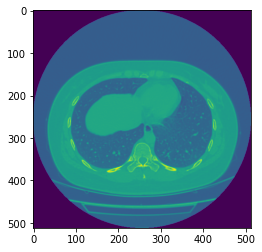

In [45]:
# reopen the data just for checking
load_filename = r"D:\data\CT-Covid-19-August2020\DICOM\volume-covid19-A-0005\0005_73.dcm"
print('Load file {} ...'.format(load_filename))
ds = pydicom.dcmread(load_filename)
print(ds)

plt.imshow(ds.pixel_array)
plt.plot